In [33]:
import time

import numpy as np


def measure_smallest_delta():
    """
    Measures the smallest time interval between consecutive calls of time

    Returns:
        tuple: (start_time, end_time, delta_time)
    """
    #start_time = time.monotonic()
    start_time = time.perf_counter()
    end_time = start_time
    while end_time == start_time:
        #end_time = time.monotonic()
        end_time = time.perf_counter()
    delta_time = end_time - start_time
    return start_time, end_time, delta_time

def estimate_precision(num_samples):
    """
    Estimates the precision of the system clock by averaging the smallest time intervals.
    Args:
        num_samples: Number of samples to collect.
    """
    smallest_deltas = [measure_smallest_delta()[2] for _ in range(num_samples)]
    average_precision = np.average(smallest_deltas)
    return average_precision

In [34]:
# System timing settings
TIMER_RESOLUTION_SAMPLES = 1000
RELATIVE_ERROR_MEASURE = 0.01

resolution = estimate_precision(TIMER_RESOLUTION_SAMPLES)
min_duration = resolution * ((1.0 / RELATIVE_ERROR_MEASURE) + 1.0)

print(f"Precision of clock: {resolution:.8f}")

print(f"With a relative error of {RELATIVE_ERROR_MEASURE:.2f}, need to measure at least a time of {min_duration:.8f} seconds.")

Precision of clock: 0.00000016
With a relative error of 0.01, need to measure at least a time of 0.00001665 seconds.


In [35]:
import time
import tracemalloc
import numpy as np


def check_time_taken(graph, algorithm, start, target, avg_samples, min_duration):
    """
    Measure the time and memory taken for multiple runs of a given algorithm on a graph and return aggregated results.

    Args:
        graph: The graph on which the operation is performed.
        algorithm: The algorithm/function to measure the time for.
        start: Starting node or parameter for the operation.
        target: Target node or parameter for the operation.
        avg_samples: Number of samples to collect for calculating mean and std.
        min_duration: Min duration for each time measurement.

    Returns:
        Tuple[float, float, float, float, float, float, float]: Aggregated results including average count of repetitions,
        average duration, median duration, standard deviation, average memory used, median memory used, and std memory used.
    """

    results = []

    # Checks time and memory taken multiple times
    for _ in range(avg_samples):
        start_time, end_time, count, duration, memory_used = check_time_taken_single_run(graph, algorithm, start, target, min_duration)
        results.append((start_time, end_time, count, duration, memory_used))

    # Extract relevant information for aggregation
    durations = [item[3] for item in results]
    memories = [item[4] for item in results]

    # Calculate aggregated values
    avg_duration = sum(durations) / len(durations)
    median_duration = sorted(durations)[len(durations) // 2]
    std_duration = np.std(durations)

    avg_memory_used = sum(memories) / len(memories)
    median_memory_used = sorted(memories)[len(memories) // 2]
    std_memory_used = np.std(memories)

    # Return the aggregated results as a tuple
    return avg_duration, median_duration, std_duration, avg_memory_used, median_memory_used, std_memory_used


def check_time_taken_single_run(graph, algorithm, start, target, min_duration):
    """
    Measure the time taken for a single run of a given algorithm on a graph.

    Args:
        graph: The graph on which the operation is performed.
        algorithm: The algorithm/function to measure the time for.
        start: Starting node or parameter for the operation.
        target: Target node or parameter for the operation.

    Returns:
        Tuple[float, float, int, float]: Start time, End time, Count of repetitions, Duration of the operation.
    """
    tracemalloc.start()
    count = 0  # Counter for the number of repetition
    start_time = end_time = 0.0 # Initialize start and end time
    start_time = time.perf_counter()
    while end_time - start_time <= min_duration: # Loop until we get to the min duration
        algorithm(graph, start, target) # Execute the algorithm
        end_time = time.perf_counter()
        count += 1 # Keep a counter to know how many loops we performed
    current, peak = tracemalloc.get_traced_memory()
    #print(f"Current memory: {current}, Peak memory: {peak}")
    tracemalloc.clear_traces()
    # Return the results as a tuple
    # save peak if you are concerned about the maximum memory footprint of your code
    # save current if you are interested in the memory usage at a specific moment,
    return (start_time, end_time, count, end_time - start_time, peak)

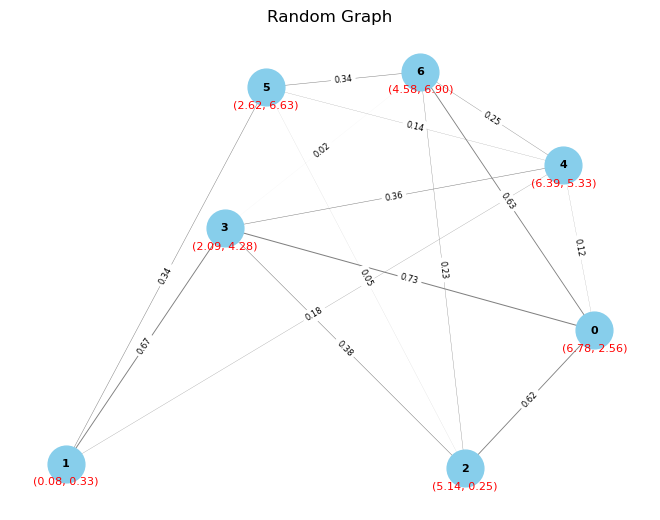

In [36]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Global variables for weight range
min_weight = 0.01
max_weight = 1.0
decimal_places = 3
SEED = 123

def generate_random_graph(nodes, edges, seed=SEED):
    max_edges = (nodes * (nodes - 1)) // 2
    if edges > max_edges:
        print(f"WARNING: Random graph - Number of edges ({edges}) exceeds the maximum possible for a random graph ({max_edges}).")
    edges = min(edges, max_edges)

    G_gnm = nx.gnm_random_graph(nodes, edges, seed)

    # Avoid self-loops
    G_gnm.remove_edges_from(nx.selfloop_edges(G_gnm))

    # Assign random weights to edges
    for edge in G_gnm.edges():
        G_gnm[edge[0]][edge[1]]['weight'] = np.random.uniform(min_weight, max_weight)

    # Assign random 2D coordinates to nodes
    for node in G_gnm.nodes():
        G_gnm.nodes[node]['coord2d'] = (np.random.uniform(0., nodes), np.random.uniform(0., nodes))

    return G_gnm


def plot_graph_topology(graph):
    pos = nx.get_node_attributes(graph, 'coord2d')
    weights = [graph[u][v]['weight'] for u, v in graph.edges()]

    nx.draw(graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=8, width=weights, edge_color='gray')

    for node, (x, y) in pos.items():
        plt.text(x, y-0.3, f'({x:.2f}, {y:.2f})', fontsize=8, ha='center', va='center', color='red')

    edge_labels = {(u, v): f'{graph[u][v]["weight"]:.2f}' for u, v in graph.edges()}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=6)

    plt.title("Random Graph")
    plt.show()

# Example usage:
nodes = 7
edges = 15
seed = 99

random_graph = generate_random_graph(nodes, edges, seed)
plot_graph_topology(random_graph)

In [37]:
def generate_instance(num_nodes, min_edges_factor=0.5, max_edges_factor=1.0):
    if num_nodes <= 0:
        raise ValueError("Number of nodes must be greater than 0.")

    min_edges = int(min_edges_factor * num_nodes)
    max_edges = int(max_edges_factor * (num_nodes * (num_nodes - 1)) // 2)

    if min_edges >= max_edges:
        max_edges = min_edges + 1

    num_edges = np.random.randint(min_edges, max_edges)

    random_graph = generate_random_graph(num_nodes, num_edges)

    return random_graph

100%|██████████| 100/100 [00:00<00:00, 1052.97it/s]


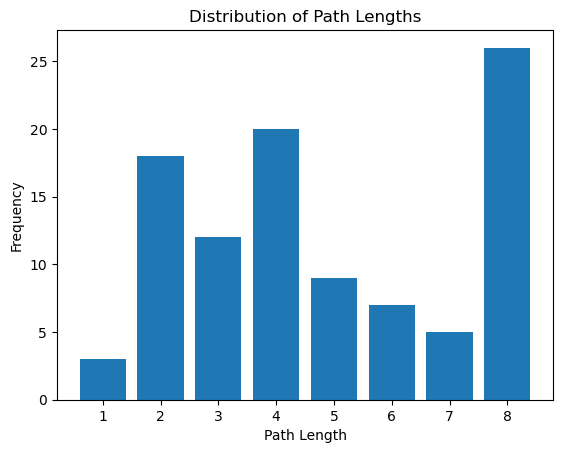

In [38]:
import networkx as nx
import random
from tqdm import tqdm

def random_start_and_target(graph):
    # Get a list of all nodes in the graph
    nodes_list = list(graph.nodes())

    # Ensure that the graph is not empty
    if not nodes_list:
        raise ValueError("Graph is empty, cannot choose nodes.")
    
    tries=0
    while tries<100:
        # Randomly select a starting node
        start_node = random.choice(nodes_list)

        # Randomly select a target node
        target_node = random.choice(nodes_list)

        # Check if the target node is reachable from the starting node
        if nx.has_path(graph, start_node, target_node):
            return start_node, target_node
    
    return None, None

def repeat_and_plot(n_instances, max_num_nodes):
    path_lengths = []

    for _ in tqdm(range(n_instances)):
        graph = generate_instance(np.random.randint(3, max_num_nodes))
        start, target = random_start_and_target(graph)

        if start is None:
            continue
        
        # Compute the path using DFS edges
        path = list(nx.dfs_edges(graph, start, target))
        path_length = len(path) + 1  # Adding 1 for the target node

        path_lengths.append(path_length)

    # Plotting
    plt.hist(path_lengths, bins=range(min(path_lengths), max(path_lengths) + 1), align='left', rwidth=0.8)
    plt.title('Distribution of Path Lengths')
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.show()

# Example usage:
repeat_and_plot(100, 10)


In [39]:
def calculate_trials(num_nodes):
    # Adjust the constant as needed
    constant = 500
    trials = max(1, int(constant / num_nodes))
    return trials

In [40]:
import heapq
from collections import deque
import math


def dijkstra(graph, start, target):
    # Priority queue for Dijkstra's algorithm
    pq = [(0, start, [])]
    visited = set()

    while pq:
        (cost, node, path) = heapq.heappop(pq)

        if node not in visited:
            visited.add(node)
            path = path + [node]

            if node == target:
                return path

            for neighbor in graph.neighbors(node):
                heapq.heappush(pq, (cost + graph[node][neighbor]['weight'], neighbor, path))

    return None  # No path found


def heuristic_cost_estimate(graph, node, target):
    # Euclidean distance as a heuristic for A*
    x1, y1 = graph.nodes[node]['coord2d']
    x2, y2 = graph.nodes[target]['coord2d']
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)


def astar(graph, start, target):
    # Priority queue for A* algorithm
    pq = [(0 + heuristic_cost_estimate(graph, start, target), 0, start, [])]
    visited = set()

    while pq:
        (cost, actual_cost, node, path) = heapq.heappop(pq)

        if node not in visited:
            visited.add(node)
            path = path + [node]

            if node == target:
                return path

            for neighbor in graph.neighbors(node):
                heapq.heappush(pq, (actual_cost + graph[node][neighbor]['weight'] + heuristic_cost_estimate(graph, neighbor, target), actual_cost + graph[node][neighbor]['weight'], neighbor, path))

    return None  # No path found


def dfs(graph, start, target):
    stack = [(start, [start])]
    visited = set()

    while stack:
        (node, path) = stack.pop()

        if node not in visited:
            visited.add(node)

            if node == target:
                return path

            for neighbor in graph.neighbors(node):
                stack.append((neighbor, path + [neighbor]))

    return None  # No path found


def bfs(graph, start, target):
    queue = deque([(start, [start])])
    visited = set()

    while queue:
        (node, path) = queue.popleft()

        if node not in visited:
            visited.add(node)

            if node == target:
                return path

            for neighbor in graph.neighbors(node):
                queue.append((neighbor, path + [neighbor]))

    return None  # No path found

def bidirectional_search(graph, start, target):
    forward_queue = deque([(start, [start])])
    backward_queue = deque([(target, [target])])
    
    forward_visited = set()
    backward_visited = set()

    while forward_queue and backward_queue:
        forward_node, forward_path = forward_queue.popleft()
        backward_node, backward_path = backward_queue.popleft()

        forward_visited.add(forward_node)
        backward_visited.add(backward_node)

        # Check if the searches meet in the middle
        if forward_node in backward_visited:
            backward_path.reverse()
            return forward_path + backward_path[1:]

        # Explore neighbors in the forward direction
        for neighbor in graph.neighbors(forward_node):
            if neighbor not in forward_visited:
                forward_queue.append((neighbor, forward_path + [neighbor]))

        # Explore neighbors in the backward direction
        for neighbor in graph.neighbors(backward_node):
            if neighbor not in backward_visited:
                backward_queue.append((neighbor, backward_path + [neighbor]))

    return None  # No path found

def randomized_shortest_path(graph, start, target):
    current_node = start
    path = [start]

    while current_node != target:
        neighbors = list(graph.neighbors(current_node))
        if not neighbors:
            return None  # No path found

        next_node = np.random.choice(neighbors)
        path.append(next_node)
        current_node = next_node

    return path

def floyd_warshall(graph, start, target):
    nodes = graph.nodes
    dist = {i: {j: float('inf') for j in nodes} for i in nodes}
    next_node = {i: {j: None for j in nodes} for i in nodes}

    for i in nodes:
        dist[i][i] = 0
        for j in graph.neighbors(i):
            weight = graph[i][j].get('weight', 1)
            dist[i][j] = weight
            next_node[i][j] = j

    for k in nodes:
        for i in nodes:
            for j in nodes:
                if dist[i][k] + dist[k][j] < dist[i][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
                    next_node[i][j] = next_node[i][k]

    # Reconstruct path
    path = []
    current = start
    while current != target:
        if current is None:
            return None
        path.append(current)
        current = next_node[current][target]

    path.append(target)
    return path

def best_first_search(graph, start, target):
    def heuristic_cost_estimate(node, target):
        # Manhattan distance as a heuristic
        x1, y1 = graph.nodes[node]['coord2d']
        x2, y2 = graph.nodes[target]['coord2d']
        return abs(x1 - x2) + abs(y1 - y2)

    open_set = [(heuristic_cost_estimate(start, target), start, [])]
    visited = set()

    while open_set:
        _, current, path = heapq.heappop(open_set)

        if current == target:
            return path + [current]

        if current not in visited:
            visited.add(current)

            for neighbor in graph.neighbors(current):
                if neighbor not in visited:
                    new_path = path + [current]
                    priority = heuristic_cost_estimate(neighbor, target)
                    heapq.heappush(open_set, (priority, neighbor, new_path))

    return None  # No path found

def bidirectional_astar(graph, start, target):
    forward_open_set = [(heuristic_cost_estimate(graph, start, target), 0, start, [])]
    backward_open_set = [(heuristic_cost_estimate(graph, target, start), 0, target, [])]
    forward_visited = set()
    backward_visited = set()

    while forward_open_set and backward_open_set:
        _, forward_actual_cost, forward_current, forward_path = heapq.heappop(forward_open_set)
        _, backward_actual_cost, backward_current, backward_path = heapq.heappop(backward_open_set)

        if forward_current == backward_current:
            # Merge the paths
            backward_path.reverse()
            return forward_path + backward_path[1:]

        if forward_current not in forward_visited:
            forward_visited.add(forward_current)

            for neighbor in graph.neighbors(forward_current):
                if neighbor not in forward_visited:
                    new_path = forward_path + [forward_current]
                    forward_g_cost = forward_actual_cost + graph[forward_current][neighbor].get('weight', 1)
                    forward_h_cost = heuristic_cost_estimate(graph, neighbor, target)
                    forward_f_cost = forward_g_cost + forward_h_cost
                    heapq.heappush(forward_open_set, (forward_f_cost, forward_g_cost, neighbor, new_path))

        if backward_current not in backward_visited:
            backward_visited.add(backward_current)

            for neighbor in graph.neighbors(backward_current):
                if neighbor not in backward_visited:
                    new_path = backward_path + [backward_current]
                    backward_g_cost = backward_actual_cost + graph[backward_current][neighbor].get('weight', 1)
                    backward_h_cost = heuristic_cost_estimate(graph, neighbor, start)
                    backward_f_cost = backward_g_cost + backward_h_cost
                    heapq.heappush(backward_open_set, (backward_f_cost, backward_g_cost, neighbor, new_path))

    return None  # No path found


In [41]:
import time
from tqdm import tqdm

# Define the algorithms you want to test
algorithms = [dijkstra, dfs, bfs, astar, floyd_warshall, bidirectional_search, randomized_shortest_path, bidirectional_astar, best_first_search]

# Function to test algorithms on a graph
def test_algorithms(graph, start, target):
    results = {}

    for algo in tqdm(algorithms, desc="Testing Algorithms"):
        path = algo(graph, start, target)
        avg_duration, _, _, _, _, _ = check_time_taken(graph, algo, start, target, 100, min_duration)

        results[algo.__name__] = {"path": path, "elapsed_time": avg_duration}

    return results


# Example usage:
num_nodes = 5
min_edges_factor = 0.1
max_edges_factor = 0.5

# Generate a random graph
sample_graph = generate_instance(num_nodes, min_edges_factor, max_edges_factor)

# Choose start and target nodes
start_node, target_node = random_start_and_target(sample_graph)
start_node, target_node = 3, 0

# Test algorithms on the sample graph
algorithm_results = test_algorithms(sample_graph, start_node, target_node)

# Print the results
# Print the results with aligned output
for algo, result in algorithm_results.items():
    path = result["path"]
    elapsed_time = result["elapsed_time"]
    print(f"{algo: <25} (completed in {elapsed_time * 1000:.4f} milliseconds): {path}")



Testing Algorithms: 100%|██████████| 9/9 [00:00<00:00, 142.87it/s]

dijkstra                  (completed in 0.0249 milliseconds): [3, 0]
dfs                       (completed in 0.0213 milliseconds): [3, 0]
bfs                       (completed in 0.0194 milliseconds): [3, 0]
astar                     (completed in 0.0294 milliseconds): [3, 0]
floyd_warshall            (completed in 0.1225 milliseconds): [3, 0]
bidirectional_search      (completed in 0.0263 milliseconds): [3, 0, 0]
randomized_shortest_path  (completed in 0.0642 milliseconds): [3, 0]
bidirectional_astar       (completed in 0.1131 milliseconds): [3, 0]
best_first_search         (completed in 0.0250 milliseconds): [3, 0]


In [42]:
import pickle
import os


def manage_saving(file, obj):
    if os.path.isfile(file):
        with open(file, "ab") as f:
            pickle.dump(obj, f)
    else:
        with open(file, "wb") as f:
            pickle.dump(obj, f)

In [43]:
import datetime
import pickle
import numpy as np
from tqdm import tqdm
import networkx as nx

# List of algorithms to test
algorithms = [dijkstra, dfs, bfs, astar, floyd_warshall, bidirectional_search,
              randomized_shortest_path, bidirectional_astar, best_first_search]

# Parameters
num_graphs = 2000
min_nodes = 10
max_nodes = 100

min_edges_factor = 0.01
max_edges_factor = 0.25

num_st_trials = 3

# List of nodes
# Include max_nodes in the range
list_of_possible_nodes = list(range(min_nodes, max_nodes + 1))

# Generate the list of graphs with random node counts
list_of_possible_nodes = list(np.random.choice(
    list_of_possible_nodes, num_graphs, replace=True))

# Create and save the dataset
dataset = []

# Save the dataset to a .pkl file
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
filename = f"./instances/pathfinding_dataset_{timestamp}.pkl"

for i in tqdm(range(num_graphs)):
    # Generate a graph instance
    num_nodes = np.random.choice(list_of_possible_nodes)
    list_of_possible_nodes.remove(num_nodes)

    graph = generate_instance(num_nodes, min_edges_factor=min_edges_factor,
                              max_edges_factor=max_edges_factor)  # type: ignore

    # Run algorithms and collect times
    avg_samples = calculate_trials(num_nodes)
    timings_per_algorithm = {algo: [] for algo in algorithms}
    spaces_per_algorithm = {algo: [] for algo in algorithms}

    for _ in range(num_st_trials):
        start_node, target_node = random_start_and_target(
            graph)  # type: ignore

        if start_node is None:
            continue

        for algo in algorithms:
            # avg_duration, median_duration, std_duration, avg_memory_used, median_memory_used, std_memory_used
            avg_duration, _, _, avg_memory_used, _, _ = check_time_taken(
                graph, algo, start_node, target_node, avg_samples, min_duration)
            timings_per_algorithm[algo].append(avg_duration)
            spaces_per_algorithm[algo].append(avg_memory_used)

    # Calculate mean of means for each algorithm
    mean_of_means_time = {algo: np.mean(
        timings) for algo, timings in timings_per_algorithm.items()}
    mean_of_means_space = {algo: np.mean(
        spaces) for algo, spaces in spaces_per_algorithm.items()}

    # Identify the best algorithm based on the mean of means
    best_algo_time = min(mean_of_means_time,
                         key=mean_of_means_time.get)  # type: ignore
    best_algo_space = min(mean_of_means_space,
                          key=mean_of_means_space.get)  # type: ignore

    # Save the dataset entry
    entry = {"graph": graph, "label_time": best_algo_time.__name__,
             "label_space": best_algo_space.__name__}
    dataset.append(entry)

    if (i+1)%10==0:
        manage_saving(filename, dataset)
        dataset.clear()

100%|██████████| 2000/2000 [2:38:16<00:00,  4.75s/it]  


In [44]:
import os
import pickle

folder_path = "./instances/"  # Replace with the path to your folder containing pickle files
dataset = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".pkl"):
        file_path = os.path.join(folder_path, filename)
        
        # Open each pickle file and append its content to the dataset
        with open(file_path, "rb") as f:
            try:
                while True:
                    file_data = pickle.load(f)
                    dataset.extend(file_data)
            except EOFError:
                pass

Percentages for Time:
astar                   : 0.05000
best_first_search       : 64.95000
bfs                     : 4.05000
bidirectional_astar     : 0.00000
bidirectional_search    : 9.65000
dfs                     : 15.75000
dijkstra                : 2.55000
randomized_shortest_path: 3.00000

Percentages for Space:
astar                   : 19.85000
best_first_search       : 55.25000
bfs                     : 0.00000
bidirectional_astar     : 0.10000
bidirectional_search    : 0.60000
dfs                     : 12.95000
dijkstra                : 0.00000
randomized_shortest_path: 11.25000


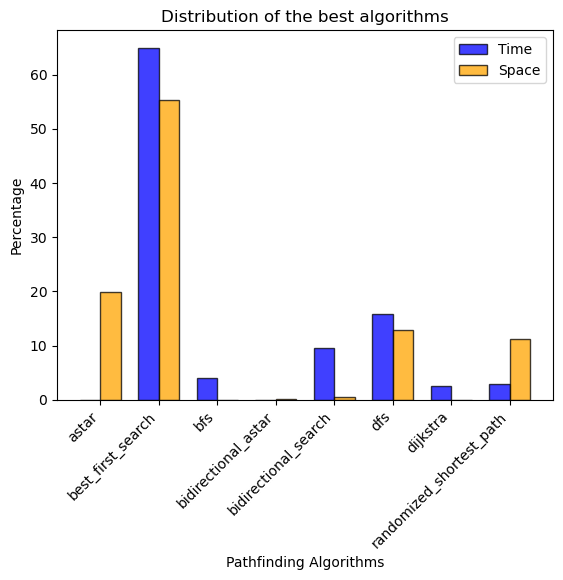

In [45]:
import pickle
import matplotlib.pyplot as plt
import numpy as np


# Extract labels (both label_time and label_space)
labels_time = [entry["label_time"] for entry in dataset]
labels_space = [entry["label_space"] for entry in dataset]

# Get unique labels and their counts
unique_labels = np.unique(labels_time + labels_space)
counts_time = [labels_time.count(label) for label in unique_labels]
counts_space = [labels_space.count(label) for label in unique_labels]

# Calculate percentages
total_time = sum(counts_time)
total_space = sum(counts_space)
percentages_time = [count / total_time * 100 for count in counts_time]
percentages_space = [count / total_space * 100 for count in counts_space]

# Determine the maximum label length for padding
max_label_length = max(len(label) for label in unique_labels)

# Print percentages with padding
print("Percentages for Time:")
for label, percentage in zip(unique_labels, percentages_time):
    print(f"{label.ljust(max_label_length)}: {percentage:.5f}")

print("\nPercentages for Space:")
for label, percentage in zip(unique_labels, percentages_space):
    print(f"{label.ljust(max_label_length)}: {percentage:.5f}")

# Set up bar positions
bar_width = 0.35
index = np.arange(len(unique_labels))

# Plot the distribution of labels for time
plt.bar(index, percentages_time, bar_width, label='Time', color='blue', alpha=0.75, edgecolor='black')

# Plot the distribution of labels for space
plt.bar(index + bar_width, percentages_space, bar_width, label='Space', color='orange', alpha=0.75, edgecolor='black')

# Customize the plot
plt.xlabel('Pathfinding Algorithms')
plt.ylabel('Percentage')
plt.title('Distribution of the best algorithms')
plt.xticks(index + bar_width / 2, unique_labels, rotation=45, ha="right")
plt.legend()

# Show the plot
plt.show()


In [46]:
len(dataset)

2000

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Split the DataFrame into train and test sets
df_train, df_test = train_test_split(dataset, test_size=0.1, random_state=99, shuffle=True)

# Convert the result to DataFrames if needed
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

# Save the train set
df_train.to_pickle("df_train.pkl")

# Save the test set
df_test.to_pickle("df_test.pkl")
